In [80]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns

from datetime import datetime
from sklearn.svm import SVR
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
% config InlineBackend.figure_format = 'png'
% matplotlib inline

In [81]:
def read_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

# Read the dataset
train = read_data("../data/train.csv")
test = read_data("../data/test.csv")

In [82]:
def parse_date(data):
    
    # Assume a date which is later than latest opening date of all the restaurants
    latest_date = datetime.strptime("01/01/2015", '%m/%d/%Y')
    
    open_num_days = []
    open_month = []
    open_year = []

    for date in data['Open Date']:
        cur_date = datetime.strptime(date, '%m/%d/%Y')
        open_num_days.append((latest_date - cur_date).days)
        open_month.append(cur_date.month)
        open_year.append(cur_date.year)

    data['Days'] = open_num_days
    data['Month'] = open_month
    data['Year'] = open_year
    del data["Open Date"]
    
    return data

In [83]:
# Calculate number of samples in training and test datasets
num_train = train.shape[0]
num_test = test.shape[0]

In [84]:
# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, "Open Date" : "P37"], test.loc[:, "Open Date" : "P37"]), ignore_index=True)

In [85]:
# Parse date of opening of restaurant to get the number of days it has stayed open, month in which it opened
# and year in which it opened. The additional month and year features can potentially help proxy seasonality
# differences since restaurant revenues are highly cylical.
data = parse_date(data)

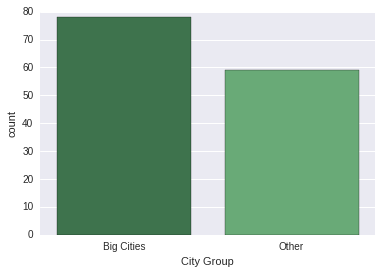

In [86]:
# The two categories of City Group both appear very frequently
sns.countplot(x='City Group', data=train, palette="Greens_d")

# One hot encode City Group
data = data.join(pd.get_dummies(data['City Group'], prefix="CG"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns.
data = data.drop(["City Group", "CG_Other"], axis=1)

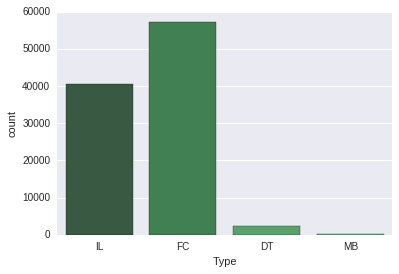

In [87]:
# Two of the four Restaurant Types (DT and MB), are extremely rare
sns.countplot(x='Type', data=data, palette="Greens_d")

# One hot encode City Group
data = data.join(pd.get_dummies(data['Type'], prefix="T"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns. Also drop the extremely rare restaurant types.
data = data.drop(["Type", "T_MB", "T_DT"], axis=1)

In [88]:
# Replace city names with count of their frequency
city_counts = data["City"].value_counts()
data["City"] = data["City"].replace(city_counts)

In [89]:
# Split into train and test datasets
train_processed = data[:num_train]
test_processed = data[num_train:]

In [90]:
lin_clf = svm.LinearSVR()
lin_clf.fit(train_processed, train["Revenue"])
results_svm = lin_clf.predict(test_processed)

In [91]:
rf = RandomForestRegressor()
rf.fit(train_processed, train["Revenue"])
results_rf = rf.predict(test_processed)

In [92]:
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=results_rf)
submission.index.name = 'Id'
# Write out the submission
submission.to_csv("../simple2.csv")